
### Deep Reconstruction-Classification Networks for Unsupervised Domain Adaptation (DRCN) ###

This code is an implementation in pytorch of the DRCN algorithm presented in [1], as applied to transferring results from SVHN to MNIST. A similar implementation exists at [2]. I have been unable to replicate Ghifary et al.'s results, but have reached results similar to [2]

[1] M. Ghifary, W. B. Kleijn, M. Zhang, D. Balduzzi, and W. Li. "Deep Reconstruction-Classification Networks for Unsupervised Domain Adaptation (DRCN)", European Conference on Computer Vision (ECCV), 2016

[2] https://github.com/fungtion/DRCN

First, clone the git repository to obtain the necessary modules

In [ ]:
!git clone https://github.com/pmirallesr/DRCN-Torch
!cd DRCN-Torch

## INITIALIZATION ##

In [ ]:
# Imports
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import math
import time # To time performance
from itertools import product
from data.data_transforms import ImpulseDenoising, GaussianDenoising
import methods.learners.DRCN as DRCN
from utils.utils import setSeeds, imshow, calcExperimentsAmount, create_zip_name, weights_init


import tensorflow as tf # Good for logging experiments
import datetime # Good for naming stuff
from torchsummary import summary # Good for understanding our network


In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Hyperparameters ##
use the dictionary experimentRanges to define series of experiments to be run
lossControlPenalty is the lambda parameter in the original DRCN paper and trades-off autoencoder loss vs labeller loss.

In [ ]:
# Hyperparameters
nbEpochs = 50
train_batch_size = 64
test_batch_size = 64

dropoutChance = 0.5
# denseLayerNeurons = 1024
# lossControlPenalty = 0.7 # controlPenalty = 0.4...0.7
sourceDataset = "SVHN"
targetDataset = "MNIST"
optimizerName = "RMSProp" #Adam or RMSProp
sourceChannels = 3

# experimentRanges[variable] = [val1, val2] sets up an experiment with val1, val 2.
# All cross combination possibilities of experiment ranges will be used.
# variable = valX sets the variable to that value instead, no experimenting.
# They may both be used simulatenously, but experimentRanges[var] overrides var
# The total number of experiments is product(len(experimentRanges[var])) over all vars
# in experimentRanges, or 1 if experimentRanges is empty.
# experimentRanges[var] = val1 and var = val1 are functionally dentical statements
experimentRanges = {}
experimentRanges["lossControlPenalty"] = [0.7]
experimentRanges["denseLayerNeurons"] = [1024]

alpha = 0.9 #Only relevant for RMSProp, smoothing constant for weight update
base_learningRate = 5e-6
experimentRanges["learningRate"] = [1e-4]
experimentRanges["weight_decay"] = [5e-6]

dataPath = os.path.dirname(os.getcwd()) + "/data/"
log_dir = os.path.dirname(os.getcwd()) + "/logs/"

randomSeed = 1905

In [ ]:
# Sets all seeds to the chosen number
setSeeds(randomSeed) 
# Creates the logging directory
os.makedirs(log_dir, exist_ok = True)
f = open(log_dir + "experimentRanges.txt", 'w')
f.write(str(experimentRanges))
f.close()

## DATA LOADING ##

We apply several transformations to both MNIST and SVHN

Both datasets are augmented with random rotations of 20 degrees. The original paper also called for random translations of 20% of the image's width, and randomly dropping pixels of each image with a 50% chance per pixel (Impulse noise)

Additionally SVHN is grayscaled and MNIST is rescaled to 32x32 pixels through a bilinear interpolation

In [ ]:
# Data Transforms

# image data augments are performed on all images before they're transformed to tensors
# tensor data augments are performed on all images after they're transformed to tensors
# MNIST / SVHN transforms are performed only on MNIST / SVHN data, and include a toTensor transformation

# Data Augmentation - Geometric Transformations
# 20º random rotation
# 20% random height and width shifts
imageDataAugmentTransforms = []
# imageDataAugmentTransforms.append(torchvision.transforms.RandomAffine(degrees = 20))
#imageDataAugmentTransforms.append(torchvision.transforms.RandomAffine(degrees = 20, translate = (0.2, 0.2)))

# Denoising
tensorDataAugmentTransforms = []
# tensorDataAugmentTransforms.append(ImpulseDenoising())
# tensorDataAugmentTransforms.append(GaussianDenoising(0.2, multiplicative))


MNIST_Transforms = []
MNIST_Transforms.append(torchvision.transforms.Resize((32,32), interpolation = 2)) #Rescale to SVHN size
MNIST_Transforms.append(torchvision.transforms.ToTensor())

SVHN_Transforms = []
# SVHN_Transforms.append(torchvision.transforms.Grayscale())
SVHN_Transforms.append(torchvision.transforms.ToTensor())

In [9]:
# Create the data loaders

train_MNIST_loader = torch.utils.data.DataLoader \
                (torchvision.datasets.MNIST(dataPath, \
                train = True, download = True, \
                transform = torchvision.transforms.Compose\
                (imageDataAugmentTransforms + MNIST_Transforms + tensorDataAugmentTransforms)), batch_size = train_batch_size, shuffle = True)

test_MNIST_loader = torch.utils.data.DataLoader \
                (torchvision.datasets.MNIST(dataPath, \
                train = False, download = True, \
                transform = torchvision.transforms.Compose\
                (MNIST_Transforms)), batch_size = test_batch_size, shuffle = True)

#DataLoader has irregular behaviour, does not autom create an SVHN folder but does so for MNIST
train_SVHN_loader = torch.utils.data.DataLoader \
                (torchvision.datasets.SVHN(dataPath + "SVHN/", \
                split = "train", download = True, \
                transform = torchvision.transforms.Compose\
                (imageDataAugmentTransforms + SVHN_Transforms + tensorDataAugmentTransforms)), batch_size = train_batch_size, shuffle = True)

test_SVHN_loader = torch.utils.data.DataLoader \
                (torchvision.datasets.SVHN(dataPath + "SVHN/", \
                split = "test", download = True , \
                 transform = torchvision.transforms.Compose \
                (SVHN_Transforms)), batch_size = test_batch_size, shuffle = True)


Extracting //data/MNIST/raw/train-images-idx3-ubyte.gz to //data/MNIST/raw


Extracting //data/MNIST/raw/train-labels-idx1-ubyte.gz to //data/MNIST/raw


Extracting //data/MNIST/raw/t10k-images-idx3-ubyte.gz to //data/MNIST/raw




Extracting //data/MNIST/raw/t10k-labels-idx1-ubyte.gz to //data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


We show an example batch of both source and target to check the transforms applied


Source Domain batch


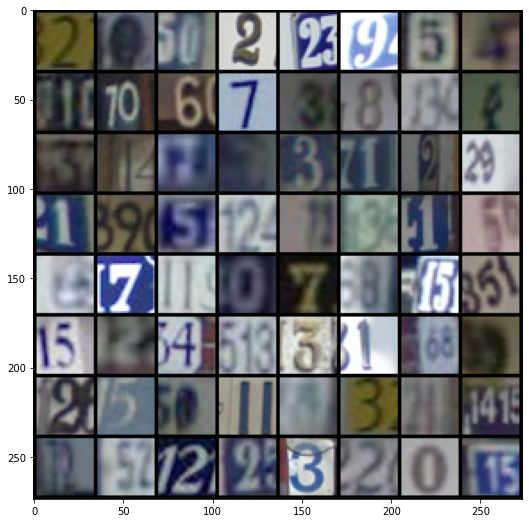

Target Domain batch


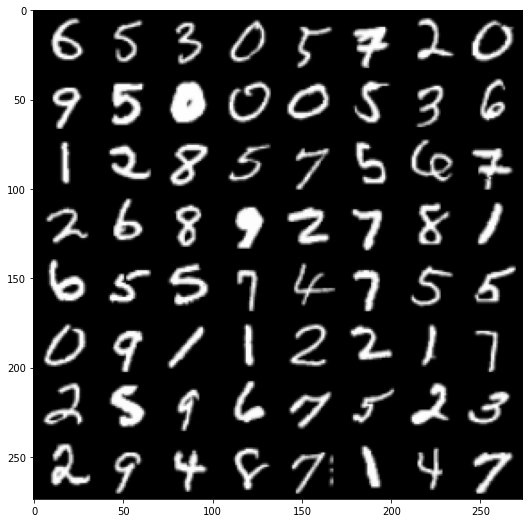

In [11]:
# get some random training images from source
batch_id, (images, labels) = next(enumerate(train_SVHN_loader))
print('Source Domain batch')
imshow(torchvision.utils.make_grid(images))

# get some random training images from target
batch_id, (images, labels) = next(enumerate(train_MNIST_loader))
print('Target Domain batch')
imshow(torchvision.utils.make_grid(images))

In [ ]:
def getSettings():
  settings = {}
  settings["optimizer"] = optimizerName
  settings["learningRate"] = learningRate
  if(optimizerName == "RMSProp"):
    settings["weight_decay"] = weight_decay
    settings["alpha"] = alpha
  settings["Epochs"] = nbEpochs
  settings["train_batch_size"] = train_batch_size
  settings["test_batch_size"] = test_batch_size
  settings["dropoutChance"] = dropoutChance
  settings["denseLayerNeurons"] = denseLayerNeurons
  settings["lossControlPenalty"] = lossControlPenalty
  settings["randomSeed"] = randomSeed
  return settings

## DRCN ##

The architecture of DRCN is simple: An autoencoder and a convolutional labeller with a common encoder body. We alternatively train the autoencoder to reconstruct inputs from the target domain and the labeller to label inputs from the source domain. The network slowly becomes better at both tasks, sacrificing some labelling performance in exchange for some reconstruction performance.

We then take the labeller, trained on the source domain, and apply it to the target domain.

In [22]:
# Create experiments from expRanges configuration dict
experiments = product(*list(experimentRanges.values()), repeat=1)
#Experiments to be run
totalExp = calcExperimentsAmount(experimentRanges)
start_at_exp = 1 # Controls experiments to be ignored
nExp = 0 #experiment counter
# Run all the experiments
for experimentParams in experiments:
    nExp += 1
    if(nExp < start_at_exp): # Skip already done experiments
        continue
    # Assign and print this experiment's parameters
    for n in range(len(experimentParams)):
        paramName = list(experimentRanges.keys())[n]
        exec("%s = %f" % (paramName, experimentParams[n])) #Paramname = experimentParams[n]
        print("{}: {}".format(paramName, experimentParams[n]))
    
    #Run this experiment
    
    # Create network
    encoder = Encoder(sourceChannels, dropoutChance = dropoutChance, denseLayerNeurons = int(denseLayerNeurons)).to(device)
    labeller = Labeller(encoder).to(device)
    autoencoder = Autoencoder(encoder).to(device)
    # Custom initialize for conv layers
    autoencoder.apply(weights_init).to(device)
    
    # Print network summary
    _, (example, _) = next(enumerate(train_SVHN_loader))
    summary(labeller, example.shape[1:])
    summary(autoencoder, example.shape[1:])
    
    # Init optimizer
    if(optimizerName == "Adam"):
      labeller_optimizer = torch.optim.Adam(labeller.parameters(), lr = 3*learningRate)
      autoencoder_optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 3*learningRate)
    elif(optimizerName == "RMSProp"):
      labeller_optimizer = torch.optim.RMSprop(labeller.parameters(), lr=learningRate, weight_decay=weight_decay, alpha = alpha)
      autoencoder_optimizer = torch.optim.RMSprop(autoencoder.parameters(), lr=learningRate, weight_decay=weight_decay, alpha = alpha)
    # Init loss criteria
    labellerCriterion = nn.CrossEntropyLoss()
    autoencoderCriterion = nn.MSELoss()
    
    # Create tensorboard log folder
    log_dir = os.path.dirname(os.getcwd()) + \
                "/logs/" "{}-{}, ".format(sourceDataset, targetDataset) + \
                "experiment parameters: {}, ".format(experimentParams) + \
                "{} epochs.".format(nbEpochs) + \
                datetime.datetime.now().strftime("Date - %Y%m%d-%H%M")
    os.makedirs(log_dir, exist_ok = True)
    
    # Write settings log
    f = open(log_dir + "/settings.txt", 'w')
    f.write(str(getSettings()))
    f.close()
    
    # Set train modes
    encoder.train()
    labeller.train()
    autoencoder.train()
    
    # To keep track of performance during eval
    bestTargetAccuracy = 0
    bestSourceAccuracy = 0
    prev_source_train_accuracy = 0
    prev_source_test_accuracy = 0
    prev_target_train_accuracy = 0
    prev_target_test_accuracy = 0
    
    # To keep timing
    avgEpochTime = 0
    start = time.time()
    # Verbosity controls
    batchesVerbosity = 50
    
    # More variables for printing advancement and tensorboard
    SVHNBatches = int(73300/train_batch_size) #SVHN size
    MNISTBatches = int(60000/train_batch_size) #MNIST size
    train_summary_writer = tf.summary.create_file_writer(log_dir)
    test_summary_writer = tf.summary.create_file_writer(log_dir)
    
    # The nets are evaluated every N periods
    validationPeriod = 5

    #Start training
    print("Training for {} epochs. Batch size {}, {} and {} batches per epoch of source and target respectively".format(nbEpochs, train_batch_size, SVHNBatches, MNISTBatches))
    for epoch in range(1, nbEpochs + 1):
        if ((epoch%validationPeriod == 0) or (epoch < validationPeriod)):
            labeller.eval()
            # Start with a t=0 validation run
            print("Validation run")
            print("--------------")
            with torch.no_grad():
                # Log source train accuracy
                (_, _, source_train_accuracy) = getLabellingAccuracy(train_SVHN_loader, labeller)
                print("Accuracy (Train) on SVHN: {:2.2f}%, {:+2.2f}%".format(source_train_accuracy, source_train_accuracy - prev_source_train_accuracy))
                with train_summary_writer.as_default():
                    tf.summary.scalar('Source_train_accuracy', source_train_accuracy, epoch)
                prev_source_train_accuracy = source_train_accuracy
                # Log source test accuracy
                (_, _, source_test_accuracy) = getLabellingAccuracy(test_SVHN_loader, labeller)        
                print("Accuracy (Test) on SVHN: {:2.2f}%, {:+2.2f}%".format(source_test_accuracy, source_test_accuracy - prev_source_test_accuracy))
                print("{:+2.2f}% with respect to maximum of {:2.2f}%".format(source_test_accuracy - bestSourceAccuracy, bestSourceAccuracy)) 
                if source_test_accuracy > bestSourceAccuracy:
                    print("Best accuracy on source so far!")
                    bestSourceAccuracy = source_test_accuracy
                    # bestSourceAccuracySettings = getSettings()
                with test_summary_writer.as_default():
                    tf.summary.scalar('Source_test_accuracy', source_test_accuracy, epoch)
                prev_source_test_accuracy = source_test_accuracy
                # # Log target train accuracy
                # (_, _, target_train_accuracy) = getLabellingAccuracy(train_MNIST_loader, labeller)
                # print("Accuracy (Train) on MNIST: {:2.2f}%, {:+2.2f}%".format(target_train_accuracy, target_train_accuracy - prev_target_train_accuracy)) 
                # with train_summary_writer.as_default():
                #     tf.summary.scalar('Target_train_accuracy', target_train_accuracy, epoch)
                # prev_target_train_accuracy = target_train_accuracy
                # # Log target test accuracy
                # (_, _, target_test_accuracy) = getLabellingAccuracy(test_MNIST_loader, labeller)
                # print("Accuracy (Test) on MNIST: {:2.2f}%, {:+2.2f}%".format(target_test_accuracy, target_test_accuracy - prev_target_test_accuracy))  
                # print("{:+2.2f}% gap with respect to maximum of {:2.2f}%".format(target_test_accuracy - bestTargetAccuracy, bestTargetAccuracy)) 
                # if target_test_accuracy > bestTargetAccuracy:
                #     print("Best accuracy on target so far!")
                #     bestTargetAccuracy = target_test_accuracy
                #     # bestTargetAccuracySettings = getSettings()
                # with test_summary_writer.as_default():
                #     tf.summary.scalar('Target_test_accuracy', target_test_accuracy, epoch)
                # prev_target_test_accuracy = target_test_accuracy

            labeller.train()
        print("--------------")

        # Timekeeping
        epochStart = time.time()
        
        # Train on target dataset
        # print("Target")
        # for batch_id, (data, target) in enumerate(train_MNIST_loader):
        #     autoencoder_optimizer.zero_grad()
        #     autoencoder.zero_grad()
        #     encoder.zero_grad()
        #     data = data.to(device)
        #     target = target.to(device)
        #     forward = autoencoder(data)
        #     data = torch.tensor(data, dtype = torch.double, requires_grad=True).to(device)
        #     autoencoderLoss = autoencoderCriterion(forward, data)
        #     autoencoderLoss *= (1 - lossControlPenalty)
        #
        #     # Log performance to tensorboard  
        #     with train_summary_writer.as_default():
        #         index = epoch*MNISTBatches + batch_id
        #         tf.summary.scalar('Autoencoder_Loss', autoencoderLoss.item(), index)
        #     if(batch_id%batchesVerbosity == 0):
        #         print("Target batch {}, epoch {}. Loss = {:.5f}".format(batch_id, epoch, autoencoderLoss.item()))           
        #     autoencoderLoss.backward()
        #     autoencoder_optimizer.step()

        # Train on source dataset
        print("Source")
        for batch_id, (data, target) in enumerate(train_SVHN_loader):
            labeller_optimizer.zero_grad()
            labeller.zero_grad()
            encoder.zero_grad()
            data = data.to(device)
            target = target.to(device)
            forward = labeller(data).to(device)
            labellerLoss = labellerCriterion(forward, target)
            labellerLoss *= lossControlPenalty # Apply the loss control penalty
            
            # Log performance to tensorboard
            with train_summary_writer.as_default():
                index = epoch*SVHNBatches + batch_id
                tf.summary.scalar('Labeller Loss', labellerLoss.item(), index)
            if(batch_id%batchesVerbosity == 0):
                print("Source batch {}, epoch {}. Loss = {:.5f}".format(batch_id, epoch, labellerLoss.item()))
            labellerLoss.backward()
            labeller_optimizer.step()
        
        # Timekeeping and print advancement
        epochEnd = time.time()
        avgEpochTime = (avgEpochTime*(epoch-1) + (epochEnd - epochStart)) / epoch
        print("--------------")
        print("Experiment: {}/{}".format(nExp,totalExp))
        print("Epoch {}/{} completed in {:.5f} minutes".format(epoch, nbEpochs, (epochEnd - epochStart)/60))
        print("{:.3f} minutes elapsed".format((epochEnd - start)/60))
        print("{:.2f} minutes remaining".format(avgEpochTime/60 * (nbEpochs - epoch)))
        print("--------------")

        
print("DONE!")
    

lossControlPenalty: 0.7
denseLayerNeurons: 1024
learningRate: 0.0001
weight_decay: 5e-06
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 100, 32, 32]           7,600
         MaxPool2d-2          [-1, 100, 16, 16]               0
            Conv2d-3          [-1, 150, 16, 16]         375,150
         MaxPool2d-4            [-1, 150, 8, 8]               0
            Conv2d-5            [-1, 200, 8, 8]         270,200
            Linear-6                 [-1, 1024]      13,108,224
         Dropout2d-7                 [-1, 1024]               0
            Linear-8                 [-1, 1024]       1,049,600
         Dropout2d-9                 [-1, 1024]               0
          Encoder-10                 [-1, 1024]               0
           Linear-11                   [-1, 10]          10,250
Total params: 14,821,024
Trainable params: 14,821,024
Non-trainable params: 0


In [23]:
create_zip_name(experimentRanges)
if(zipName == ""):
    zipName = "no_name"
# zipName = "Baseline" #zip name override

# For google colab, make and download experiments zip
# logsFolder = "{}.zip".format(zipName)
# !zip -r $logsFolder /logs/
# from google.colab import files
# files.download("/content/" + logsFolder)

  adding: logs/ (stored 0%)
  adding: logs/SVHN-MNIST, experiment parameters: (0.7, 1024, 0.0001, 5e-06), 50 epochs.Date - 20200609-1001/ (stored 0%)
  adding: logs/SVHN-MNIST, experiment parameters: (0.7, 1024, 0.0001, 5e-06), 50 epochs.Date - 20200609-1001/settings.txt (deflated 29%)
  adding: logs/SVHN-MNIST, experiment parameters: (0.7, 1024, 0.0001, 5e-06), 50 epochs.Date - 20200609-1001/events.out.tfevents.1591696867.b08766c7b022.119.5.v2 (deflated 9%)
  adding: logs/SVHN-MNIST, experiment parameters: (0.7, 1024, 0.0001, 5e-06), 50 epochs.Date - 20200609-1001/events.out.tfevents.1591696867.b08766c7b022.119.13.v2 (deflated 7%)
  adding: logs/SVHN-MNIST, experiment parameters: (0.7, 1024, 0.0001, 5e-06), 50 epochs.Date - 20200609-1125/ (stored 0%)
  adding: logs/SVHN-MNIST, experiment parameters: (0.7, 1024, 0.0001, 5e-06), 50 epochs.Date - 20200609-1125/settings.txt (deflated 29%)
  adding: logs/SVHN-MNIST, experiment parameters: (0.7, 1024, 0.0001, 5e-06), 50 epochs.Date - 202006